In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from gluonts.dataset.repository import dataset_recipes

from uni2ts.eval_util.data import get_gluonts_test_dataset
from uni2ts.eval_util.plot import plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule
from uni2ts.model.moirai2 import Moirai2Forecast, Moirai2Module

/root/miniconda3/envs/TSFMs/lib/python3.10/site-packages/uni2ts/common/env.py:43: UserWarning: Failed to load .env file.
  warnings.warn("Failed to load .env file.")


### Settings
SIZE: model size, select the model size of Moirai to perform inference with

CTX: context length, how many time steps the model will take as input for inference

PSZ: patch size, how many time steps to perform patching with

BSZ: batch size, number of samples in each batch for inference

In [2]:
MODEL = "moirai2"  # model name: choose from {'moirai', 'moirai-moe', 'moirai2'}
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
CTX = 1000  # context length: any positive integer
PSZ = "32"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer

### Prepare datasets and model

In [3]:
# List of available datasets:
sorted(dataset_recipes.keys())

['ETTh1',
 'ETTh2',
 'ETTm1',
 'ETTm2',
 'METR_LA',
 'airpassengers',
 'australian_electricity_demand',
 'bitcoin',
 'bitcoin_with_missing',
 'car_parts_with_missing',
 'car_parts_without_missing',
 'cif_2016',
 'cif_2016_12',
 'cif_2016_6',
 'constant',
 'covid_deaths',
 'covid_mobility',
 'dominick',
 'elecdemand',
 'electricity',
 'electricity_hourly',
 'electricity_nips',
 'electricity_weekly',
 'exchange_rate',
 'exchange_rate_nips',
 'extended_web_traffic_with_missing',
 'fred_md',
 'hospital',
 'istanbul_traffic',
 'jena_weather',
 'kaggle_web_traffic_weekly',
 'kaggle_web_traffic_with_missing',
 'kaggle_web_traffic_without_missing',
 'kdd_cup_2018_with_missing',
 'kdd_cup_2018_without_missing',
 'london_smart_meters_with_missing',
 'london_smart_meters_without_missing',
 'm1_monthly',
 'm1_quarterly',
 'm1_yearly',
 'm3_monthly',
 'm3_other',
 'm3_quarterly',
 'm3_yearly',
 'm4_daily',
 'm4_hourly',
 'm4_monthly',
 'm4_quarterly',
 'm4_weekly',
 'm4_yearly',
 'm5',
 'monash_m3_

In [4]:
# Load dataset using loader utils
test_data, metadata = get_gluonts_test_dataset(
    "electricity", prediction_length=None, regenerate=False
)
metadata

MetaData(freq='1H', target_dim=1, prediction_length=24, feat_dynamic_real_dim=0, past_feat_dynamic_real_dim=0, split='test')

In [5]:
# Prepare model
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(
            f"/root/autodl-tmp/TSFMs/pretrained/Salesforce/moirai-1.1-R-{SIZE}",
        ),
        prediction_length=metadata.prediction_length,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=metadata.target_dim,
        feat_dynamic_real_dim=metadata.feat_dynamic_real_dim,
        past_feat_dynamic_real_dim=metadata.past_feat_dynamic_real_dim,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(
            f"/root/autodl-tmp/TSFMs/pretrained/Salesforce/moirai-moe-1.0-R-{SIZE}",
        ),
        prediction_length=metadata.prediction_length,
        context_length=CTX,
        patch_size=16,
        num_samples=100,
        target_dim=metadata.target_dim,
        feat_dynamic_real_dim=metadata.feat_dynamic_real_dim,
        past_feat_dynamic_real_dim=metadata.past_feat_dynamic_real_dim,
    )
elif MODEL == "moirai2":
    model = Moirai2Forecast(
        module=Moirai2Module.from_pretrained(
            f"/root/autodl-tmp/TSFMs/pretrained/Salesforce/moirai-2.0-R-small",
        ),
        prediction_length=100,
        context_length=1680,
        target_dim=1,
        feat_dynamic_real_dim=0,
        past_feat_dynamic_real_dim=0,
    )

predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

Loading weights from local directory


### Make predictions

In [6]:
inp = next(input_it)  # input / lookback window
label = next(label_it)  # label / forecast horizon
forecast = next(forecast_it)  # predictions (GluonTS Forecast object)

In [7]:
inp.keys(), label.keys()

(dict_keys(['target', 'start', 'feat_static_cat', 'item_id']),
 dict_keys(['target', 'start', 'feat_static_cat', 'item_id']))

In [8]:
inp["target"].shape, label["target"].shape

((21044,), (24,))

Moirai produces a _probabilistic forecast_, in the form of a mixture distribution.
```forecast``` is a sample forecast, taking ```num_samples=100``` samples from the mixture distribution per time step.

In [9]:
if MODEL == "moirai2":
    print(forecast.mean)
else:
    print(forecast.samples.shape)

[ 7.371274   7.762926   8.973511   9.23679    9.568245   9.669298
  9.270709   9.471075   9.176363   8.89744    8.142629   7.399988
 12.1185055 32.990845  10.877186   7.147871   7.057131   6.1930437
  6.091651   6.6040297  6.8375473  6.363062   6.7413063  7.334346
  7.797947   8.812079   9.0913925  9.470602   9.684105   9.782472
  9.568367   9.86763    9.926996   9.825744   9.330993   8.610301
 12.790522  36.68698   13.542833   7.474307   6.782795   6.364875
  7.2321386  8.599173   7.5267706  6.7503014  6.567976   6.6205425
  7.1205063  8.626725   9.034481  10.161987  10.5325775 10.151096
 10.065119  10.309699  10.297194  10.190409   9.398383   8.957821
 14.88961   28.456993  11.83332    9.177635   8.063795   7.8558292
  7.944414   8.302712   7.8131466  7.5370283  7.101122   7.5232763
  8.174688   9.041096   9.679522  10.02398   10.24842   10.15766
 10.434115  10.439825  10.171946  10.064491   9.054116   8.550187
 13.39517   29.347654  11.482737   8.114365   7.349304   7.4636087
  7.68

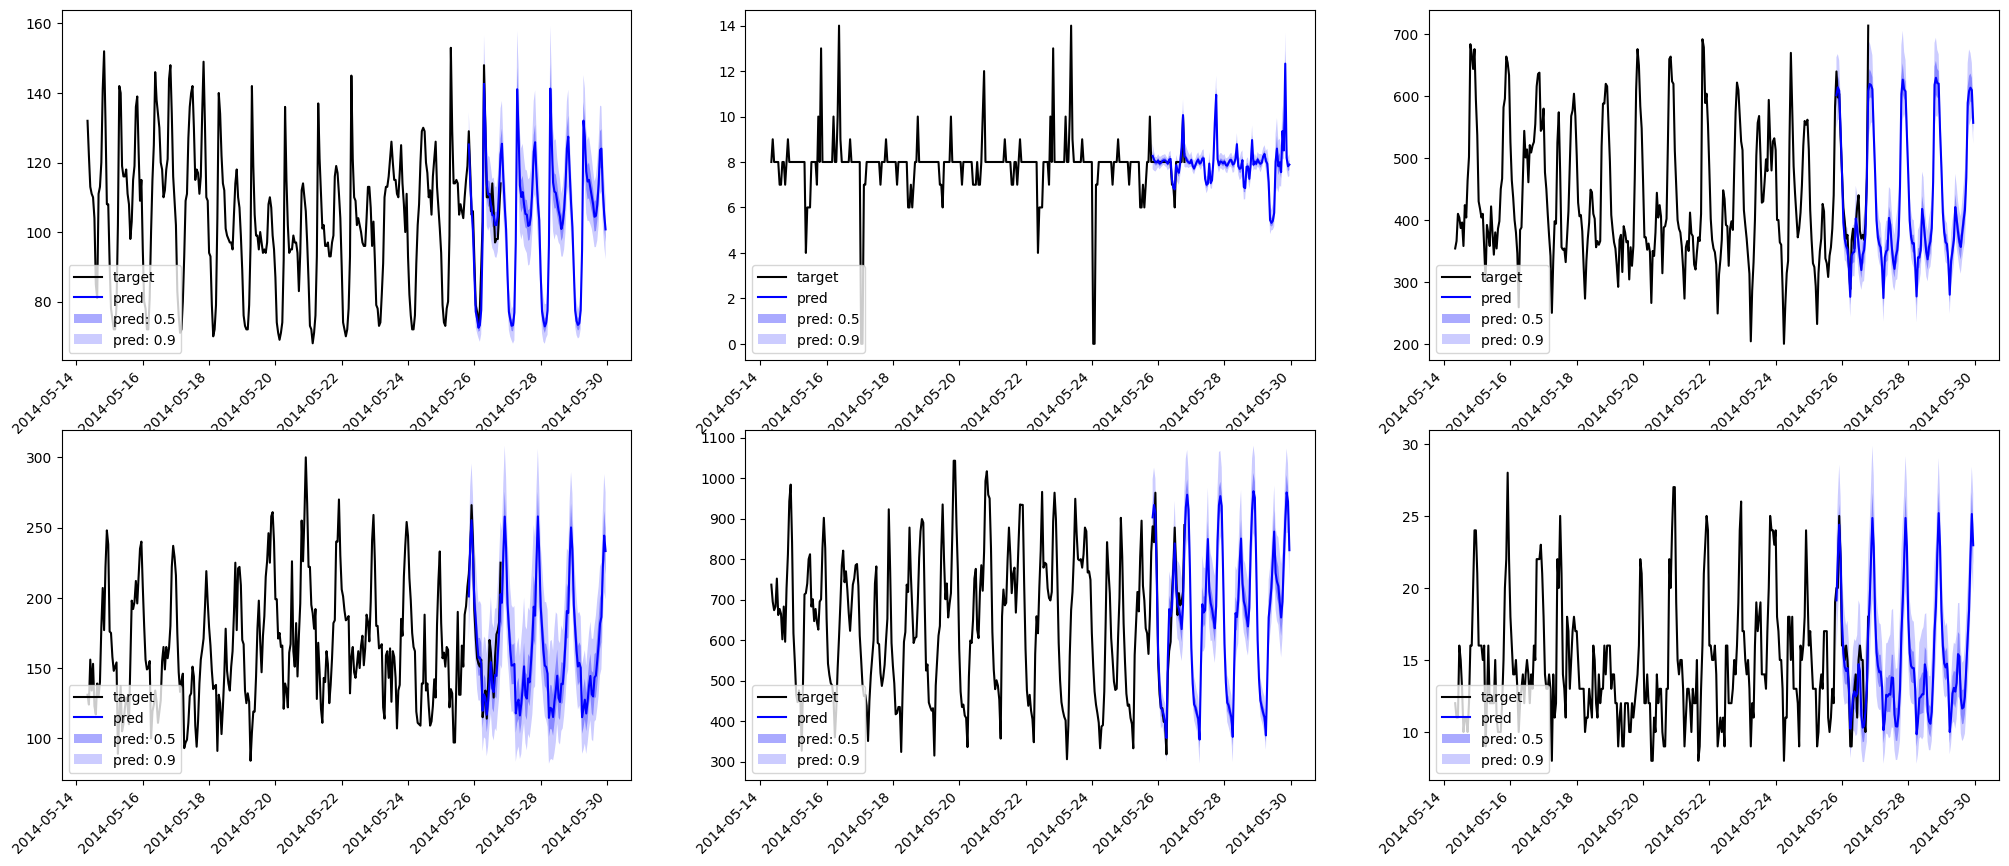

In [10]:
# Visualize forecasts
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)